In [1]:
from keras.datasets import fashion_mnist,mnist
import wandb
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy
import argparse
# import warnings
# warnings.filterwarnings('ignore')
wandb.login()


wandb: Currently logged in as: gsathish333. Use `wandb login --relogin` to force relogin


True

In [2]:
class Activation_Functions:
    def __init__(self,function):
        self.function=function
    def getActivations(self,x):
        if self.function=='relu':
            return np.maximum(0,x)
        elif self.function=='sigmoid':
            return 1.0/(1+np.exp(-x))
        elif self.function=='tanh':
            return np.tanh(x)
    def getDerivatives(self,x):
        if self.function=='relu':
             return 1*(x>0)
        elif self.function=='sigmoid':
            return sigmoid(x)*(1-sigmoid(x))
        elif self.function=='tanh':
            return (1 - (np.tanh(x)**2))         

def relu(x):
    return np.maximum(0,x)

def reluPrime(x):
    return 1*(x>0)

class Optimizers:
    def __init__(self,method):
        self.method=method
    def update(self,obj,lr,momentum=0.9,nesterov_beta=0.9,x_batch=None,y_batch=None,lambda_=0,adam_beta1=0.9,adam_beta2=0.99,rms_beta=0.9):
        if self.method=='sgd':
            for i in range(len(obj.layers)):
                obj.weights[i]=obj.weights[i]-lr*(2*lambda_*obj.weights[i]+obj.gradients_w[i])
                obj.biases[i]=obj.biases[i]-lr*obj.gradients_b[i]
        elif self.method=='momentum':
            init=0
            new_gradients=[None]*len(obj.gradients_w)
            for i in range(len(obj.layers)):
                if obj.prev_gradients_w!=None:
                    new_gradients[i]=(1-momentum)*obj.gradients_w[i]+obj.prev_gradients_w[i]*momentum
                else:
                    new_gradients[i]=lr*obj.gradients_w[i]
                    
                obj.weights[i]=obj.weights[i]-lr*(new_gradients[i]+2*lambda_*obj.weights[i])
            obj.prev_gradients_w=new_gradients
            
            
            pass
        elif self.method=='rmsprop':
            for i in range(len(obj.layers)):
                obj.rms_v[i]=rms_beta*obj.rms_v[i]+(1-rms_beta)*(obj.gradients_w[i]**2)
                
                obj.weights[i]=obj.weights[i]-(lr/(np.sqrt(obj.rms_v[i])+1e-9))*(obj.gradients_w[i])
                 
                obj.biases[i]=obj.biases[i]-lr*obj.gradients_b[i] 
                
        elif self.method=='adam':
            for i in range(len(obj.layers)):
                obj.adam_m[i]=adam_beta1*obj.adam_m[i]+(1-adam_beta1)*obj.gradients_w[i]
                m_hat=obj.adam_m[i]/(1-np.power(adam_beta1,obj.counter))
                
                obj.adam_v[i]=adam_beta2*obj.adam_v[i]+(1-adam_beta2)*obj.gradients_w[i]*obj.gradients_w[i]
                v_hat=obj.adam_v[i]/(1-np.power(adam_beta2,obj.counter))
                obj.weights[i]=obj.weights[i]-(lr/(np.sqrt(v_hat)+1e-9))*m_hat
                obj.biases[i]=obj.biases[i]-lr*obj.gradients_b[i]
        
        elif self.method=='nadam':
             for i in range(len(obj.layers)):
                obj.adam_m[i]=adam_beta1*obj.adam_m[i]+(1-adam_beta1)*obj.gradients_w[i]
                m_hat=obj.adam_m[i]/(1-adam_beta1)
                
                obj.adam_v[i]=adam_beta2*obj.adam_v[i]+(1-adam_beta2)*obj.gradients_w[i]*obj.gradients_w[i]
                v_hat=obj.adam_v[i]/(1-adam_beta2)
                obj.weights[i]=obj.weights[i]-(lr/(np.sqrt(v_hat)+10))*m_hat
                
                obj.weights[i]=obj.weights[i]-(lr*(np.divide((adam_beta1*m_hat)+((1-adam_beta1)/(1-np.power(adam_beta1,obj.counter)))*obj.gradients_w[i],np.sqrt(v_hat)+1e-9)))
                obj.biases[i]=obj.biases[i]-lr*obj.gradients_b[i]
        elif self.method=='nesterov':
            original_weights=obj.weights.copy()
            original_graidents=obj.gradients_w.copy()
            if obj.prev_gradients_w!=None:
                 for i in range(len(obj.layers)):
                        obj.weights[i]=obj.weights[i]-nesterov_beta*obj.gradients_w[i]
            
            layer_outs,inter_values=obj.forward(x_batch)
            loss=cross_entropy_loss(layer_outs[-1],y_batch)
            if np.isnan(loss):
                print("* layer outs"*50)
                print(layer_outs[-1])
                print("* y batch"*50)
                print(y_batch)
#             loss=0
            obj.compute_deltas(layer_outs,inter_values,y_batch)
            obj.find_gradients(x_batch,layer_outs)
            
            for i in range(len(obj.gradients_w)):
                if obj.prev_gradients_w!=None:
                    obj.gradients_w[i]=original_graidents[i]*nesterov_beta+obj.gradients_w[i]
                obj.weights[i]=original_weights[i]-lr*(obj.gradients_w[i]+2*lambda_*obj.weights[i])
            obj.prev_gradients_w=True
            return loss




def sigmoid(x):
    return 1.0/(1.0+1.0*np.exp(-x))
def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanhPrime(x):
    return (1 - (np.tanh(x)**2))

def intialize_weights(method,rows,cols):
    if method=='uniform':
        return np.random.rand(rows,cols)
    elif method=='xavier':
        return np.random.randn(rows,cols)*np.sqrt(2/(rows+cols))
    else:
        return np.random.randn(rows,cols)

def soft_max(x):
    max_=np.max(x,axis=0)
    x=x-max_
    return np.exp(x)/np.sum(np.exp(x),axis=0)

def soft_max_prime(x):
    return soft_max(x)*(1-soft_max(x))
    

class OneHotEncoder:
    def __init__(self,max_):
        self.max_=max_
    def transform(self,x):
        out=np.zeros((len(x),self.max_))
        out[np.arange(len(x)),x]=1
        return out.T

def cross_entropy_loss(y_pre,y):
    y_pre[y_pre<1e-15]=1e-15
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[1])

def getSig():
    return lambda x:1.0/(1+np.exp(-x))

def pre_process(x):
    x=x.reshape(-1,784)
    x=x/255
    return x

In [3]:
class NN:
    def __init__(self,input_size,layers,active_func='sigmoid',weights_init='xavier'):
        self.input_size=input_size
        self.layers=layers
        self.nlayers=len(layers)
        self.activations=Activation_Functions(wandb.config.activation)
        self.optimizer=Optimizers(wandb.config.optimizer)
        self.weights=[]
        self.weights.append(intialize_weights(weights_init,layers[0],input_size))
        self.deltas=[None]*self.nlayers
        self.gradients_w=[None]*self.nlayers
        self.gradients_b=[None]*self.nlayers
        self.prev_gradients_w=None
        self.counter=1
        self.biases=[]
        self.batch_size=wandb.config.batch_size
        for i in range(1,len(layers)):
            self.weights.append(intialize_weights(weights_init,layers[i],layers[i-1]))
        for i in range(len(layers)):
            self.biases.append(np.random.randn(layers[i],1))   
        
        if self.optimizer.method in ['adam','nadam']:
            self.adam_m=copy.deepcopy(self.weights)
            self.adam_v=copy.deepcopy(self.adam_m)
            _=[each.fill(0) for each in self.adam_m]
            _=[each.fill(0) for each in self.adam_v]
        if self.optimizer.method=='rmsprop':
            self.rms_v=copy.deepcopy(self.weights)
            _=[each.fill(0) for each in self.rms_v]
        
        
    def forward(self,x):
        layer_outputs=[]
        inter_values=[]
        
        for i in range(len(self.weights)):
            inter_values.append(self.weights[i].dot(x)+self.biases[i])
            if i!= len(self.weights)-1:
                layer_outputs.append(self.activations.getActivations(inter_values[-1]))
                x=layer_outputs[-1]
        layer_outputs.append(soft_max(inter_values[-1]))
        return layer_outputs,inter_values
    def compute_deltas(self,layer_outputs,inter_values,y_one_hot):
#         self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)*soft_max_prime(inter_values[self.nlayers-1])
        self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)
        
        for i in range(self.nlayers-2,-1,-1):
            self.deltas[i]=np.matmul(self.weights[i+1].T,self.deltas[i+1])*self.activations.getDerivatives(inter_values[i])
        
    def find_gradients(self,x,layer_outs):
        self.gradients_w[0]=(np.matmul(self.deltas[0],x.T)+2*wandb.config.L2_lambda*self.weights[0])/self.batch_size
        for i in range(1,self.nlayers):
            self.gradients_w[i]=(np.dot(self.deltas[i],layer_outs[i-1].T)+2*wandb.config.L2_lambda*self.weights[i])/self.batch_size
        for i in range(self.nlayers):
            self.gradients_b[i]=np.sum(self.deltas[i],keepdims=True)/self.batch_size
             
    def update_weights(self,lr):
        for each in range(self.nlayers):
            self.optimizer.update(self,lr=0.1)
    
            
    def train(self,x,y,x_valid,y_valid,epochs=1):
        lr=wandb.config.learning_rate
        batch_size=wandb.config.batch_size
        train_losses=[]
        valid_losses=[] 
        epochs=wandb.config.epochs
        for epoch in range(xepochs):                
            i=0
            batch_count=0
            loss=0.0
            while i+batch_size < x.shape[1]:
                batch_count+=1
                x_batch=x[:,i:i+batch_size]
                y_batch=y[:,i:i+batch_size]
                i+=batch_size
                if self.optimizer.method!='nesterov':
                    layer_outs,inter_values=self.forward(x_batch)
                    loss+=cross_entropy_loss(layer_outs[-1],y_batch)
                    self.compute_deltas(layer_outs,inter_values,y_batch)
                    self.find_gradients(x_batch,layer_outs)
                    self.optimizer.update(self,lr,0.1,lambda_=0.0005)
                else:
                    loss+=self.optimizer.update(self,lr,0.001,x_batch=x_batch,y_batch=y_batch,lambda_=0.0005)
                self.counter+=1
                    
            train_losses.append(loss/batch_count)
            layer_outs,inter_values=self.forward(x_valid)
            valid_loss=cross_entropy_loss(layer_outs[-1],y_valid)/(y_valid.shape[1])
            valid_losses.append(valid_loss)
            print(f"epoch {epoch+1} : train loss = {train_losses[-1]} valid loss = {valid_loss}")
            
            
        tr_ac=self.calc_accuracy(x,y)
        val_ac=self.calc_accuracy(x_valid,y_valid)
        print("train accuracy ",tr_ac)
        print("valid accuracy ",val_ac);
        wandb.log({'accuracy':tr_ac,'val_accuracy':val_ac})
        return train_losses,valid_losses
    
    def predict_probas(self,x):
        layer_outs,inter_values=self.forward(x)
        return layer_outs[-1]
        
    def calc_accuracy(self,x,y):
        layer_outs,inter_values=self.forward(x)
        pred=np.argmax(layer_outs[-1],axis=0)
        expected=np.argmax(y,axis=0)
        
        return (np.sum(pred==expected)/y.shape[1])*100
        
        

In [4]:
def load_data(dataset='fashion_mnist'):
    if dataset=='fashion_mnist':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train,x_valid=x_train[:int(len(x_train)*0.8)],x_train[int(len(x_train)*0.8):] #splitting train into train and valid
    y_train,y_valid=y_train[:int(len(y_train)*0.8)],y_train[int(len(y_train)*0.8):]

    x_train=pre_process(x_train)
    x_valid=pre_process(x_valid)
    x_test=pre_process(x_test) 
    
    one_hot=OneHotEncoder(10)
    y_train=one_hot.transform(y_train)
    y_valid=one_hot.transform(y_valid)
    y_test=one_hot.transform(y_test)
    
    
    return x_train,y_train,x_valid,y_valid,x_test,y_test
    

x_train,y_train,x_valid,y_valid,x_test,y_test=load_data()

In [5]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'  
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'num_layers':{
            'values':[3,4,5]
        },
         'layer_size':{
            'values':[32,64,128]
        },
        'L2_lambda':{
            'values':[0,0.0005,0.5]
        },
         'learning_rate':{
            'values':[0.1,0.01,0.001]
        },
         'optimizer': {
            'values': ['sgd','momentum','nesterov','rmsprop','adam','nesterov']
        },
        'batch_size': {
            'values': [16,32,64]
        },
         'intialization':{
            'values':['normal','random','xavier']
        },
        'activation': {
            'values': ['sigmoid','tanh','relu']
        },      
        
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='main_sweeps_V3')

Create sweep with ID: 2g44jjcf
Sweep URL: https://wandb.ai/gsathish333/main_sweeps_V3/sweeps/2g44jjcf


In [34]:
def main():
    with wandb.init() as run:
        layer_size=wandb.config.layer_size
        num_layers=wandb.config.num_layers
        layers=[layer_size]*num_layers
        layers.append(10)
        obj=NN(784,layers)
        train_losses,valid_losses=obj.train(x_train.T,y_train,x_valid.T,y_valid)
    
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: 69uccak8 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: sgd


epoch 1 : train loss = 1.5077584181044346 valid loss = 7.341736303439495e-05
epoch 2 : train loss = 0.7658766764343988 valid loss = 5.5418321916522455e-05
epoch 3 : train loss = 0.6378783679551191 valid loss = 4.819583884319766e-05
epoch 4 : train loss = 0.575243291905668 valid loss = 4.489843442166284e-05
epoch 5 : train loss = 0.5411583263082237 valid loss = 4.254730244662275e-05
train accuracy  82.88333333333333
valid accuracy  82.29166666666666


accuracy,▁
val_accuracy,▁
accuracy,82.88333
val_accuracy,82.29167


wandb: Agent Starting Run: pome64lw with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


epoch 1 : train loss = 1.496320305675561 valid loss = 7.10149626279799e-05
epoch 2 : train loss = 0.7443355061287537 valid loss = 5.274269954950156e-05
epoch 3 : train loss = 0.6115788588802396 valid loss = 4.6689399939771086e-05
epoch 4 : train loss = 0.555178837684948 valid loss = 4.3076989622156356e-05
epoch 5 : train loss = 0.5149499346095565 valid loss = 4.0304612878735215e-05
train accuracy  84.0625
valid accuracy  83.5


accuracy,▁
val_accuracy,▁
accuracy,84.0625
val_accuracy,83.5


wandb: Agent Starting Run: yc7iesme with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


epoch 1 : train loss = 0.7790258470403844 valid loss = 4.160088737017853e-05
epoch 2 : train loss = 0.5250809893853642 valid loss = 3.7560733906828165e-05
epoch 3 : train loss = 0.4765041113396134 valid loss = 3.6015571266187986e-05
epoch 4 : train loss = 0.45787100342738674 valid loss = 3.359235438414717e-05
epoch 5 : train loss = 0.44101018702441713 valid loss = 3.361148739159296e-05
train accuracy  86.08125
valid accuracy  85.41666666666666


accuracy,▁
val_accuracy,▁
accuracy,86.08125
val_accuracy,85.41667


wandb: Agent Starting Run: l8r0e8b7 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:8: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-x))
/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:105: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+1.0*np.exp(-x))


epoch 1 : train loss = 1.2462674501891624 valid loss = 0.00010372638854554555
epoch 2 : train loss = 1.1080625174261511 valid loss = 7.889587357677668e-05
epoch 3 : train loss = 1.117739190073255 valid loss = 8.998979385020585e-05
epoch 4 : train loss = 1.1771969752103972 valid loss = 9.840894271270367e-05
epoch 5 : train loss = 1.1803111201682606 valid loss = 0.00010978083922833916
train accuracy  62.860416666666666
valid accuracy  62.824999999999996


accuracy,▁
val_accuracy,▁
accuracy,62.86042
val_accuracy,62.825


wandb: Agent Starting Run: vqdqpmo0 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: adam


/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:8: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-x))
/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:105: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+1.0*np.exp(-x))


epoch 1 : train loss = 1.3242938482870015 valid loss = 0.00010551096868543053
epoch 2 : train loss = 1.3181179782344052 valid loss = 0.00010786601400615333
epoch 3 : train loss = 1.275252602610528 valid loss = 0.00010994205834490089
epoch 4 : train loss = 1.250268250985646 valid loss = 9.749311009487356e-05
epoch 5 : train loss = 1.2011189044894635 valid loss = 0.00011628107590521146
train accuracy  45.256249999999994
valid accuracy  45.45


accuracy,▁
val_accuracy,▁
accuracy,45.25625
val_accuracy,45.45


wandb: Agent Starting Run: btgmnwca with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 4
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.3121801477957487 valid loss = 0.0001923244424011342
epoch 2 : train loss = 2.1448048379786346 valid loss = 0.00013344933677938436
epoch 3 : train loss = 1.3213101255463444 valid loss = 9.802741172515704e-05
epoch 4 : train loss = 1.0717931320403689 valid loss = 8.231819502385955e-05
epoch 5 : train loss = 0.9349938390977043 valid loss = 7.325135467721008e-05
train accuracy  67.90833333333333
valid accuracy  67.675


accuracy,▁
val_accuracy,▁
accuracy,67.90833
val_accuracy,67.675


wandb: Agent Starting Run: fbyfr1ct with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.3126303676857725 valid loss = 0.00019261568241246354
epoch 2 : train loss = 1.7806278582163273 valid loss = 0.00011077472730364626
epoch 3 : train loss = 1.191385303611526 valid loss = 9.107434472215825e-05
epoch 4 : train loss = 1.0144921285317294 valid loss = 7.799434644575048e-05
epoch 5 : train loss = 0.9011696085952664 valid loss = 7.08184591519827e-05
train accuracy  68.72916666666666
valid accuracy  68.55


accuracy,▁
val_accuracy,▁
accuracy,68.72917
val_accuracy,68.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: upwh2o59 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov


epoch 1 : train loss = 1.1874637159547718 valid loss = 5.023087234617943e-05
epoch 2 : train loss = 0.597859178003999 valid loss = 4.180395732682869e-05
epoch 3 : train loss = 0.5305298758654913 valid loss = 3.732742013244043e-05
epoch 4 : train loss = 0.4941674824867042 valid loss = 3.669265516663307e-05
epoch 5 : train loss = 0.47796685922562276 valid loss = 3.5907009691931347e-05
train accuracy  85.54375
valid accuracy  84.76666666666667


accuracy,▁
val_accuracy,▁
accuracy,85.54375
val_accuracy,84.76667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mwf5eu7 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:8: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-x))
/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:105: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+1.0*np.exp(-x))


epoch 1 : train loss = 1.531247878407172 valid loss = 9.037508772240531e-05
epoch 2 : train loss = 1.2555768967327885 valid loss = 0.00010790273927467407
epoch 3 : train loss = 1.309461912092361 valid loss = 0.00011194162088902797
epoch 4 : train loss = 1.2344073517803928 valid loss = 9.717767843661622e-05
epoch 5 : train loss = 1.4223472389883376 valid loss = 0.00010339991700742066
train accuracy  56.49999999999999
valid accuracy  56.925000000000004


accuracy,▁
val_accuracy,▁
accuracy,56.5
val_accuracy,56.925


wandb: Agent Starting Run: e31dd5yw with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 4
wandb: 	optimizer: adam


epoch 1 : train loss = 2.3226082777744588 valid loss = 0.00019365083552670847
epoch 2 : train loss = 2.319721577817625 valid loss = 0.0001936508267487356
epoch 3 : train loss = 2.3197215752480402 valid loss = 0.00019365082674637009
epoch 4 : train loss = 2.3197215752341225 valid loss = 0.0001936508267463629
epoch 5 : train loss = 2.3197215752337663 valid loss = 0.00019365082674635976
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Agent Starting Run: bppg4pc8 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 5
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.3114573971349492 valid loss = 0.00019234090319002195
epoch 2 : train loss = 2.3074814816950857 valid loss = 0.00019221528102779864
epoch 3 : train loss = 2.3070825306456197 valid loss = 0.00019218195474992656
epoch 4 : train loss = 2.3069421166409723 valid loss = 0.0001921690208334466
epoch 5 : train loss = 2.306872785299107 valid loss = 0.00019216255405628602
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Agent Starting Run: 223i9oq8 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.3137180815055283 valid loss = 0.0001927165542645174
epoch 2 : train loss = 2.3085824207329533 valid loss = 0.00019234801717103842
epoch 3 : train loss = 2.3073048173682147 valid loss = 0.0001922243592580154
epoch 4 : train loss = 2.3068273621716706 valid loss = 0.00019217879709453156
epoch 5 : train loss = 2.3066322688596346 valid loss = 0.00019215998383781914
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9dv0f3fy with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


epoch 1 : train loss = 1.7046831655132408 valid loss = 8.337647448070875e-05
epoch 2 : train loss = 0.845790904006344 valid loss = 4.865360359478527e-05
epoch 3 : train loss = 0.6357665712219502 valid loss = 4.5515886749860634e-05
epoch 4 : train loss = 0.5965939455177619 valid loss = 4.224305275144073e-05
epoch 5 : train loss = 0.541768067392295 valid loss = 3.963331539386646e-05
train accuracy  84.42083333333333
valid accuracy  83.50833333333333


accuracy,▁
val_accuracy,▁
accuracy,84.42083
val_accuracy,83.50833


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jdhd62na with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop


/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:8: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-x))
/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:105: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+1.0*np.exp(-x))


epoch 1 : train loss = 1.6289248661514948 valid loss = 0.0001524381432064075
epoch 2 : train loss = 1.452057645205803 valid loss = 0.00012503586861506191
epoch 3 : train loss = 1.6343549128005113 valid loss = 0.00014998681100593573
epoch 4 : train loss = 1.592855772932701 valid loss = 0.00014221501465036293
epoch 5 : train loss = 1.5942620228021693 valid loss = 0.00012694839416274033
train accuracy  35.01875
valid accuracy  35.233333333333334


accuracy,▁
val_accuracy,▁
accuracy,35.01875
val_accuracy,35.23333


wandb: Agent Starting Run: 8ycpmiir with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 5
wandb: 	optimizer: adam


epoch 1 : train loss = 2.3223284561511055 valid loss = 0.00019365081504890772
epoch 2 : train loss = 2.320094864675918 valid loss = 0.0001936437987931828
epoch 3 : train loss = 2.319420073514371 valid loss = 0.00019229547333121248
epoch 4 : train loss = 2.311990518082135 valid loss = 0.00019199597779173043
epoch 5 : train loss = 2.311332683021288 valid loss = 0.00019197478321169155
train accuracy  9.9875
valid accuracy  10.05


accuracy,▁
val_accuracy,▁
accuracy,9.9875
val_accuracy,10.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 57kqnic6 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.3053132423948037 valid loss = 0.00019131821422358112
epoch 2 : train loss = 2.287830986664431 valid loss = 0.0001892353816569227
epoch 3 : train loss = 2.183023251653632 valid loss = 0.00016635427484107306
epoch 4 : train loss = 1.7987975557384481 valid loss = 0.0001402158571685303
epoch 5 : train loss = 1.6178409594118404 valid loss = 0.00012893614290758639
train accuracy  39.93333333333333
valid accuracy  40.35


accuracy,▁
val_accuracy,▁
accuracy,39.93333
val_accuracy,40.35


wandb: Agent Starting Run: vsfggmvj with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.3071978439442624 valid loss = 0.0001912470767900812
epoch 2 : train loss = 2.2873663638127932 valid loss = 0.00018941359880227348
epoch 3 : train loss = 2.2190317264810036 valid loss = 0.0001745865657422678
epoch 4 : train loss = 1.8475236297901414 valid loss = 0.00013788107079651193
epoch 5 : train loss = 1.518679288720142 valid loss = 0.00011574492556027166
train accuracy  52.925
valid accuracy  53.583333333333336


accuracy,▁
val_accuracy,▁
accuracy,52.925
val_accuracy,53.58333


wandb: Agent Starting Run: 1vimf10z with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


epoch 1 : train loss = 1.5403733628181435 valid loss = 8.167919632773762e-05
epoch 2 : train loss = 0.9263441156093184 valid loss = 5.773603861317281e-05
epoch 3 : train loss = 0.7352004016493617 valid loss = 5.011010761166293e-05
epoch 4 : train loss = 0.65652670139437 valid loss = 4.5620977109227514e-05
epoch 5 : train loss = 0.6021976037579013 valid loss = 4.180830387634186e-05
train accuracy  82.27083333333334
valid accuracy  82.08333333333333


accuracy,▁
val_accuracy,▁
accuracy,82.27083
val_accuracy,82.08333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zn14olon with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


epoch 1 : train loss = 0.6596699625631322 valid loss = 4.3057490504996854e-05
epoch 2 : train loss = 0.5015126825250921 valid loss = 3.886946692341028e-05
epoch 3 : train loss = 0.47642488465278365 valid loss = 4.069469449091832e-05
epoch 4 : train loss = 0.4654524316387371 valid loss = 4.108328964885646e-05
epoch 5 : train loss = 0.4562483229850474 valid loss = 4.020968464787433e-05
train accuracy  85.37916666666666
valid accuracy  84.625


accuracy,▁
val_accuracy,▁
accuracy,85.37917
val_accuracy,84.625


wandb: Agent Starting Run: ijbxluov with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam


epoch 1 : train loss = 0.6806395603580493 valid loss = 4.6348746814989005e-05
epoch 2 : train loss = 0.5312318728325301 valid loss = 3.943033957043331e-05
epoch 3 : train loss = 0.4966904963644342 valid loss = 3.933281525411858e-05
epoch 4 : train loss = 0.47833088866935447 valid loss = 3.841383004566142e-05
epoch 5 : train loss = 0.46253306587231313 valid loss = 3.853263311570328e-05
train accuracy  84.85625
valid accuracy  83.61666666666666


accuracy,▁
val_accuracy,▁
accuracy,84.85625
val_accuracy,83.61667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6sxqjyd3 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.3107783301859164 valid loss = 0.0001918890716204877
epoch 2 : train loss = 2.303358783480011 valid loss = 0.00019185852511870182
epoch 3 : train loss = 2.302988428025615 valid loss = 0.0001918283885191567
epoch 4 : train loss = 2.30259484709842 valid loss = 0.00019179382344099345
epoch 5 : train loss = 2.302114041850276 valid loss = 0.00019174854208591456
train accuracy  9.933333333333334
valid accuracy  10.266666666666667


accuracy,▁
val_accuracy,▁
accuracy,9.93333
val_accuracy,10.26667


wandb: Agent Starting Run: s6q5dri3 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.3218615104497644 valid loss = 0.0001919024278306774
epoch 2 : train loss = 2.3036225466958924 valid loss = 0.00019188110593222412
epoch 3 : train loss = 2.303384125312696 valid loss = 0.0001918625671373847
epoch 4 : train loss = 2.3031653607015232 valid loss = 0.00019184471825980275
epoch 5 : train loss = 2.30294512003346 valid loss = 0.0001918259809477082
train accuracy  9.933333333333334
valid accuracy  10.266666666666667


accuracy,▁
val_accuracy,▁
accuracy,9.93333
val_accuracy,10.26667


wandb: Agent Starting Run: esjqtewu with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov


epoch 1 : train loss = 2.2071357465733845 valid loss = 0.00014053184648795381
epoch 2 : train loss = 1.4577181240960069 valid loss = 8.89162748009934e-05
epoch 3 : train loss = 1.0345133754928566 valid loss = 6.751549376761004e-05
epoch 4 : train loss = 0.8656639493054821 valid loss = 5.916895055986516e-05
epoch 5 : train loss = 0.7739281846014779 valid loss = 5.4843305551254515e-05
train accuracy  73.63125000000001
valid accuracy  73.54166666666667


accuracy,▁
val_accuracy,▁
accuracy,73.63125
val_accuracy,73.54167


wandb: Agent Starting Run: kyi5lzxx with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


epoch 1 : train loss = 0.7978423595347451 valid loss = 4.648331575986246e-05
epoch 2 : train loss = 0.5644027951581985 valid loss = 4.3603033471791395e-05
epoch 3 : train loss = 0.5172229709210191 valid loss = 4.385378989264923e-05
epoch 4 : train loss = 0.49507653474900754 valid loss = 4.2654293417519335e-05
epoch 5 : train loss = 0.48834733759951043 valid loss = 4.1282105115898796e-05
train accuracy  85.27708333333334
valid accuracy  84.22500000000001


accuracy,▁
val_accuracy,▁
accuracy,85.27708
val_accuracy,84.225


wandb: Agent Starting Run: pziwdbzb with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 4
wandb: 	optimizer: adam


epoch 1 : train loss = 0.8236347718289745 valid loss = 4.956730812765193e-05
epoch 2 : train loss = 0.5624678302112492 valid loss = 4.5667265287459245e-05
epoch 3 : train loss = 0.523662610312345 valid loss = 4.504216589351053e-05
epoch 4 : train loss = 0.49801712412839255 valid loss = 4.3252302308099396e-05
epoch 5 : train loss = 0.48777854496692274 valid loss = 4.156739062470926e-05
train accuracy  82.70416666666667
valid accuracy  82.40833333333333


accuracy,▁
val_accuracy,▁
accuracy,82.70417
val_accuracy,82.40833


wandb: Agent Starting Run: ml4eca3r with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.309613286814491 valid loss = 0.00019193742496448422
epoch 2 : train loss = 2.304195625686809 valid loss = 0.000191935415253536
epoch 3 : train loss = 2.304163299862654 valid loss = 0.00019193371725107974
epoch 4 : train loss = 2.304134366728746 valid loss = 0.00019193225539553772
epoch 5 : train loss = 2.3041080774105462 valid loss = 0.00019193097359078196
train accuracy  9.933333333333334
valid accuracy  10.266666666666667


accuracy,▁
val_accuracy,▁
accuracy,9.93333
val_accuracy,10.26667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xox4hjl5 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.3127107864582492 valid loss = 0.0001919118226694812
epoch 2 : train loss = 2.30365660778081 valid loss = 0.00019191118889738006
epoch 3 : train loss = 2.303646316492878 valid loss = 0.00019191075088441356
epoch 4 : train loss = 2.3036382456515097 valid loss = 0.00019191045049686187
epoch 5 : train loss = 2.3036317897698058 valid loss = 0.0001919102455324889
train accuracy  9.933333333333334
valid accuracy  10.266666666666667


accuracy,▁
val_accuracy,▁
accuracy,9.93333
val_accuracy,10.26667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0f546z04 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


epoch 1 : train loss = 2.339209146729806 valid loss = 0.00019192374275510992
epoch 2 : train loss = 2.313979084270569 valid loss = 0.00019183688003539915
epoch 3 : train loss = 2.3102321507644508 valid loss = 0.00019144760110782164
epoch 4 : train loss = 2.183950417351478 valid loss = 0.00015554280178662735
epoch 5 : train loss = 1.5781857740135679 valid loss = 0.00010563331016070251
train accuracy  46.09166666666666
valid accuracy  46.275


accuracy,▁
val_accuracy,▁
accuracy,46.09167
val_accuracy,46.275


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: thc3dd93 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop


epoch 1 : train loss = 0.9461392557984868 valid loss = 5.9073006568931476e-05
epoch 2 : train loss = 0.6985015488889658 valid loss = 5.195622367724676e-05
epoch 3 : train loss = 0.5976171486651162 valid loss = 4.6370212290891644e-05
epoch 4 : train loss = 0.5539944366106526 valid loss = 4.470157327897622e-05
epoch 5 : train loss = 0.5317073983305478 valid loss = 4.48066784017704e-05
train accuracy  83.22083333333333
valid accuracy  83.025


accuracy,▁
val_accuracy,▁
accuracy,83.22083
val_accuracy,83.025


wandb: Agent Starting Run: i13khemg with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam


epoch 1 : train loss = 1.0444829652974958 valid loss = 6.41809051169517e-05
epoch 2 : train loss = 0.7021177464888297 valid loss = 5.34284394354441e-05
epoch 3 : train loss = 0.6144497149434912 valid loss = 4.5808903576836684e-05
epoch 4 : train loss = 0.5599148593884683 valid loss = 4.369938392062034e-05
epoch 5 : train loss = 0.5352003001865655 valid loss = 4.305795780370226e-05
train accuracy  83.61458333333334
valid accuracy  83.04166666666667


accuracy,▁
val_accuracy,▁
accuracy,83.61458
val_accuracy,83.04167


wandb: Agent Starting Run: 6b3gpt2b with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.3921019895440074 valid loss = 0.00019195832644562172
epoch 2 : train loss = 2.3022640657245876 valid loss = 0.00019177535300919887
epoch 3 : train loss = 2.3010593349178365 valid loss = 0.000191687184735119
epoch 4 : train loss = 2.3000105978300276 valid loss = 0.00019159823956533859
epoch 5 : train loss = 2.2989365558256765 valid loss = 0.00019150629116964943
train accuracy  10.191666666666666
valid accuracy  9.966666666666667


accuracy,▁
val_accuracy,▁
accuracy,10.19167
val_accuracy,9.96667


wandb: Agent Starting Run: wh4e9srd with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.3752492297094525 valid loss = 0.00019184022418922513
epoch 2 : train loss = 2.3015325738092933 valid loss = 0.0001917295973322315
epoch 3 : train loss = 2.3005128118061986 valid loss = 0.00019165478246228285
epoch 4 : train loss = 2.299589351507807 valid loss = 0.00019157675324102
epoch 5 : train loss = 2.2986282300681555 valid loss = 0.0001914949364733415
train accuracy  12.039583333333333
valid accuracy  11.691666666666666


accuracy,▁
val_accuracy,▁
accuracy,12.03958
val_accuracy,11.69167


wandb: Agent Starting Run: dlhtcfw0 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


epoch 1 : train loss = 2.370765353517903 valid loss = 0.0001883452634680059
epoch 2 : train loss = 1.9750869601701764 valid loss = 0.00015167549095953034
epoch 3 : train loss = 1.6933579527752012 valid loss = 0.00013066044124029872
epoch 4 : train loss = 1.489189335367261 valid loss = 0.00011260953576352746
epoch 5 : train loss = 1.3365505553811434 valid loss = 9.972675423358332e-05
train accuracy  54.383333333333326
valid accuracy  55.48333333333333


accuracy,▁
val_accuracy,▁
accuracy,54.38333
val_accuracy,55.48333


wandb: Agent Starting Run: 04wpazb7 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


epoch 1 : train loss = 1.018168957335715 valid loss = 4.651472966692594e-05
epoch 2 : train loss = 0.5084059379352638 valid loss = 3.85425756232528e-05
epoch 3 : train loss = 0.4446140504809243 valid loss = 3.602123558546785e-05
epoch 4 : train loss = 0.4131149575436314 valid loss = 3.4195609367800625e-05
epoch 5 : train loss = 0.3924074398183928 valid loss = 3.3106787865475644e-05
train accuracy  87.27708333333334
valid accuracy  86.65


accuracy,▁
val_accuracy,▁
accuracy,87.27708
val_accuracy,86.65


wandb: Agent Starting Run: dn61umyr with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam


epoch 1 : train loss = 0.9923108668908226 valid loss = 4.619064548417634e-05
epoch 2 : train loss = 0.5033991290445026 valid loss = 3.816792799577067e-05
epoch 3 : train loss = 0.42975893363707607 valid loss = 3.431908732265306e-05
epoch 4 : train loss = 0.3889055327952276 valid loss = 3.200008306011018e-05
epoch 5 : train loss = 0.36315526060510944 valid loss = 3.105346799237222e-05
train accuracy  87.98541666666667
valid accuracy  86.75833333333334


accuracy,▁
val_accuracy,▁
accuracy,87.98542
val_accuracy,86.75833


wandb: Agent Starting Run: w0cldlza with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.4361703174853973 valid loss = 0.0001919877886696366
epoch 2 : train loss = 2.303248451655268 valid loss = 0.0001918913677830314
epoch 3 : train loss = 2.302914697848961 valid loss = 0.00019188662803011017
epoch 4 : train loss = 2.3028497569136146 valid loss = 0.00019188142514426132
epoch 5 : train loss = 2.302788268468193 valid loss = 0.00019187637276247497
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Agent Starting Run: b0u59kuh with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.416641087323918 valid loss = 0.00019209229082909788
epoch 2 : train loss = 2.3037169991848905 valid loss = 0.0001918962169145896
epoch 3 : train loss = 2.3029609864217027 valid loss = 0.00019189578190649645
epoch 4 : train loss = 2.3029019770600456 valid loss = 0.00019189180283145835
epoch 5 : train loss = 2.302852405543129 valid loss = 0.00019188774655078754
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bdqk8j3o with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov


epoch 1 : train loss = 2.430555494004866 valid loss = 0.00019224322017969756
epoch 2 : train loss = 2.3582615386174877 valid loss = 0.00019186430516990804
epoch 3 : train loss = 2.3391679871419706 valid loss = 0.00019180101622253342
epoch 4 : train loss = 2.3304798036100083 valid loss = 0.0001917064869977108
epoch 5 : train loss = 2.3245371985304453 valid loss = 0.00019153263597973275
train accuracy  17.52916666666667
valid accuracy  17.325


accuracy,▁
val_accuracy,▁
accuracy,17.52917
val_accuracy,17.325


wandb: Agent Starting Run: b18vwndm with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop


epoch 1 : train loss = 1.216620482540351 valid loss = 6.500329050351063e-05
epoch 2 : train loss = 0.6859572391054972 valid loss = 5.0123003425701604e-05
epoch 3 : train loss = 0.5655767603565158 valid loss = 4.409219369132129e-05
epoch 4 : train loss = 0.511494067163294 valid loss = 4.224316349553837e-05
epoch 5 : train loss = 0.4838995576997106 valid loss = 4.082011579556443e-05
train accuracy  83.7375
valid accuracy  83.075


accuracy,▁
val_accuracy,▁
accuracy,83.7375
val_accuracy,83.075


wandb: Agent Starting Run: fhg46abr with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam


epoch 1 : train loss = 1.2087940543596565 valid loss = 5.975359533845874e-05
epoch 2 : train loss = 0.6107542055489406 valid loss = 4.500518756304813e-05
epoch 3 : train loss = 0.4876727006228425 valid loss = 3.908441059151807e-05
epoch 4 : train loss = 0.4304126775250114 valid loss = 3.646747837075462e-05
epoch 5 : train loss = 0.3969454366571181 valid loss = 3.493080880327145e-05
train accuracy  87.075
valid accuracy  85.28333333333333


accuracy,▁
val_accuracy,▁
accuracy,87.075
val_accuracy,85.28333


wandb: Agent Starting Run: a93za4sd with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd


epoch 1 : train loss = 2.4159217980427914 valid loss = 0.0001919970683875484
epoch 2 : train loss = 2.303030507914204 valid loss = 0.00019188731853562148
epoch 3 : train loss = 2.3028782099722 valid loss = 0.00019188684474307375
epoch 4 : train loss = 2.302875917750562 valid loss = 0.00019188665731857338
epoch 5 : train loss = 2.302873677903262 valid loss = 0.00019188648139378155
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Agent Starting Run: qj68gj26 with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum


epoch 1 : train loss = 2.4371887698966743 valid loss = 0.0001929431125017748
epoch 2 : train loss = 2.3056543413563686 valid loss = 0.00019191103765611674
epoch 3 : train loss = 2.302776682065595 valid loss = 0.00019188631166824007
epoch 4 : train loss = 2.3027192190780674 valid loss = 0.00019188477087261235
epoch 5 : train loss = 2.3027148057205484 valid loss = 0.00019188445733771083
train accuracy  10.041666666666666
valid accuracy  9.833333333333332


accuracy,▁
val_accuracy,▁
accuracy,10.04167
val_accuracy,9.83333


wandb: Agent Starting Run: 6bswou4j with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov


epoch 1 : train loss = 2.397656177145225 valid loss = 0.00019197481562892364
epoch 2 : train loss = 2.34139853016168 valid loss = 0.00019189434430163792
epoch 3 : train loss = 2.326515314655079 valid loss = 0.00019189571013832952
epoch 4 : train loss = 2.320331972785117 valid loss = 0.0001918916642090051
epoch 5 : train loss = 2.317032598206781 valid loss = 0.00019188574535295873
train accuracy  9.9875
valid accuracy  10.05


accuracy,▁
val_accuracy,▁
accuracy,9.9875
val_accuracy,10.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jgi1hopm with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop


epoch 1 : train loss = 1.324133602250783 valid loss = 7.22536184272954e-05
epoch 2 : train loss = 0.7484819443009594 valid loss = 5.241769272577757e-05
epoch 3 : train loss = 0.5716467781830662 valid loss = 4.444963339795575e-05
epoch 4 : train loss = 0.5077507352917727 valid loss = 4.098728517358158e-05
epoch 5 : train loss = 0.4721503581566172 valid loss = 3.927019660673314e-05
train accuracy  85.5625
valid accuracy  84.54166666666667


accuracy,▁
val_accuracy,▁
accuracy,85.5625
val_accuracy,84.54167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p067n91r with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam


epoch 1 : train loss = 1.2137937010131683 valid loss = 6.140944937635478e-05
epoch 2 : train loss = 0.6260528778510482 valid loss = 4.663376174985368e-05
epoch 3 : train loss = 0.5254864931790747 valid loss = 4.176028770346753e-05
epoch 4 : train loss = 0.47574958100781034 valid loss = 3.90973650654122e-05
epoch 5 : train loss = 0.4424292643480768 valid loss = 3.7342402686112885e-05
train accuracy  86.26041666666666
valid accuracy  84.89999999999999


accuracy,▁
val_accuracy,▁
accuracy,86.26042
val_accuracy,84.9


wandb: Agent Starting Run: 8rnttucx with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: sgd


epoch 1 : train loss = 1.4182054076475452 valid loss = 6.790499735436014e-05
epoch 2 : train loss = 0.7312260195329264 valid loss = 5.277312258280946e-05
epoch 3 : train loss = 0.6130841206906092 valid loss = 4.547398798786802e-05
epoch 4 : train loss = 0.539252089651765 valid loss = 4.110887105032923e-05
epoch 5 : train loss = 0.5019366103670544 valid loss = 3.915148456216443e-05
train accuracy  84.25
valid accuracy  83.64166666666667


accuracy,▁
val_accuracy,▁
accuracy,84.25
val_accuracy,83.64167


wandb: Agent Starting Run: vjsd894s with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: momentum


epoch 1 : train loss = 1.4101593185077335 valid loss = 6.218108424483488e-05
epoch 2 : train loss = 0.6555750681797391 valid loss = 4.705644014651434e-05
epoch 3 : train loss = 0.5550045244517872 valid loss = 4.2748732035730086e-05
epoch 4 : train loss = 0.51672966219267 valid loss = 4.0372715795582873e-05
epoch 5 : train loss = 0.4934013697111812 valid loss = 3.880833226767233e-05
train accuracy  84.74374999999999
valid accuracy  83.875


accuracy,▁
val_accuracy,▁
accuracy,84.74375
val_accuracy,83.875


wandb: Agent Starting Run: ybpx755h with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov


epoch 1 : train loss = 0.7975048399396983 valid loss = 3.906555572398085e-05
epoch 2 : train loss = 0.4961159129688482 valid loss = 3.497365659969017e-05
epoch 3 : train loss = 0.4525069089019136 valid loss = 3.2939614247331104e-05
epoch 4 : train loss = 0.43060434422785676 valid loss = 3.1509281193833476e-05
epoch 5 : train loss = 0.41887080797445414 valid loss = 3.132049457567087e-05
train accuracy  87.33541666666666
valid accuracy  86.41666666666666


accuracy,▁
val_accuracy,▁
accuracy,87.33542
val_accuracy,86.41667


wandb: Agent Starting Run: l7hwsu2v with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop


/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:8: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-x))
/var/folders/v8/pvrhyj2x1kdb1h8pp09t18b40000gn/T/ipykernel_9102/2839676318.py:105: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+1.0*np.exp(-x))


epoch 1 : train loss = 1.6053848220692186 valid loss = 8.774399069089049e-05
epoch 2 : train loss = 1.1596295113779616 valid loss = 0.00010720344914630494
epoch 3 : train loss = 1.0922701201702403 valid loss = 8.827378324546881e-05
epoch 4 : train loss = 1.1255547362321907 valid loss = 9.13798167793655e-05
epoch 5 : train loss = 1.0800604535886702 valid loss = 9.40264418444188e-05
train accuracy  67.80833333333334
valid accuracy  67.75


accuracy,▁
val_accuracy,▁
accuracy,67.80833
val_accuracy,67.75


wandb: Agent Starting Run: cam20mmq with config:
wandb: 	L2_lambda: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	intialization: normal
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.1
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
 parser = argparse.ArgumentParser(description = 'Set Hyper Parameters')


parser.add_argument('-wp'   , '--wandb_project'  , type = str  , metavar = '', help = 'WandB Project Name (Non-Empty String)                             ')
parser.add_argument('-we'   , '--wandb_entity'   , type = str  , metavar = '', help = 'WandB Entity Name (Non-Empty String)                              ')
parser.add_argument('-d'    , '--dataset'        , type = str  , metavar = '', help = 'Dataset : ["fashion_mnist", "mnist"]                              ')
parser.add_argument('-e'    , '--epochs'         , type = int  , metavar = '', help = 'Number of Epochs (Positive Integer)                               ')
parser.add_argument('-b'    , '--batch_size'     , type = int  , metavar = '', help = 'Batch Size (Positive Integer)                                     ')
parser.add_argument('-l'    , '--loss'           , type = str  , metavar = '', help = 'Loss function : ["mean_squared_error", "cross_entropy"]           ')
parser.add_argument('-o'    , '--optimizer'      , type = str  , metavar = '', help = 'Optimizer : ["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"]')
parser.add_argument('-lr'   , '--learning_rate'  , type = float, metavar = '', help = 'Learning Rate (Positive Float)                                    ')
parser.add_argument('-m'    , '--momentum'       , type = float, metavar = '', help = 'Momentum (Positive Float)                                         ')
parser.add_argument('-beta' , '--beta'           , type = float, metavar = '', help = 'Beta (Positive Float)                                             ')
parser.add_argument('-beta1', '--beta1'          , type = float, metavar = '', help = 'Beta1 (Positive Float)                                            ')
parser.add_argument('-beta2', '--beta2'          , type = float, metavar = '', help = 'Beta2 (Positive Float)                                            ')
parser.add_argument('-eps'  , '--epsilon'        , type = float, metavar = '', help = 'Epsilon (Positive Float)                                          ')
parser.add_argument('-w_d'  , '--weight_decay'   , type = float, metavar = '', help = 'Weight Decay (Positive Float)                                     ')
parser.add_argument('-w_i'  , '--weight_init'    , type = str  , metavar = '', help = 'Weight Init : ["random", "Xavier"]                                ')
parser.add_argument('-nhl'  , '--num_layers'     , type = int  , metavar = '', help = 'Number of HIDDEN Layers (Positive Integer)                        ')
parser.add_argument('-sz'   , '--hidden_size'    , type = int  , metavar = '', help = 'Number of Neurons in Hidden Layers (Positive Integer)             ')
parser.add_argument('-a'    , '--activation'     , type = str  , metavar = '', help = 'Activation Function : ["identity", "sigmoid", "tanh", "ReLU"]     ')
parser.add_argument('-of'   , '--output_function', type = str  , metavar = '', help = 'Activation Function : ["identity", "sigmoid", "tanh", "ReLU"]     ')

# Parse the Input Args
args = parser.parse_args()



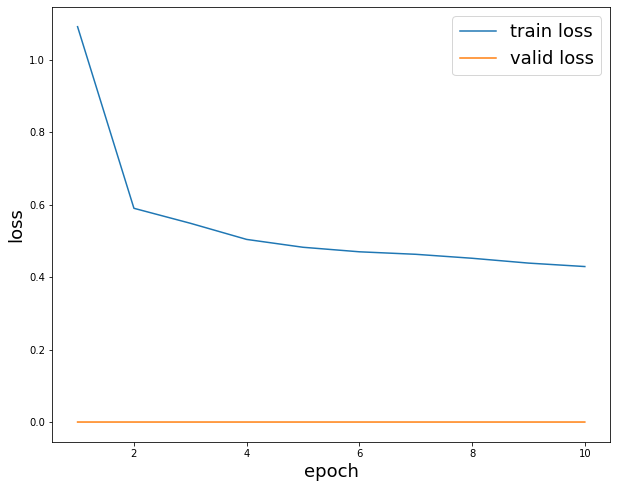

In [317]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1,len(train_losses)+1),train_losses,label='train loss')
plt.plot(np.arange(1,len(valid_losses)+1),valid_losses,label='valid loss')

plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(fontsize=18)

plt.show()

In [326]:
out=obj.predict_probas(x_train.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,np.argmax(y_train,axis=0)))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      5412
           1       0.96      0.99      0.97      4672
           2       0.78      0.78      0.78      4726
           3       0.86      0.84      0.85      4868
           4       0.72      0.77      0.74      4472
           5       0.95      0.97      0.96      4725
           6       0.60      0.66      0.63      4407
           7       0.97      0.91      0.94      5129
           8       0.97      0.93      0.95      5033
           9       0.92      0.97      0.95      4556

    accuracy                           0.86     48000
   macro avg       0.86      0.86      0.86     48000
weighted avg       0.86      0.86      0.86     48000



In [327]:
out=obj.predict_probas(x_valid.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,np.argmax(y_valid,axis=0)))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1357
           1       0.95      0.98      0.97      1166
           2       0.76      0.77      0.77      1226
           3       0.84      0.83      0.84      1222
           4       0.70      0.75      0.73      1131
           5       0.92      0.95      0.94      1160
           6       0.57      0.61      0.59      1084
           7       0.96      0.90      0.93      1269
           8       0.97      0.92      0.94      1242
           9       0.91      0.96      0.94      1143

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.85      0.84      0.84     12000



In [328]:
out=obj.predict_probas(x_test.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,np.argmax(y_test,axis=0)))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1070
           1       0.94      0.98      0.96       961
           2       0.75      0.75      0.75       999
           3       0.84      0.82      0.83      1024
           4       0.69      0.75      0.72       910
           5       0.93      0.96      0.95       968
           6       0.57      0.59      0.58       963
           7       0.97      0.88      0.93      1095
           8       0.96      0.90      0.93      1069
           9       0.90      0.96      0.93       941

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [329]:
mapping={
0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'} 

labels=list(mapping.values())

In [330]:
def plot_confusion_matrix(target,pred):
    plt.figure(figsize=(14,8))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix(target,pred),cmap=plt.cm.Blues,annot_kws={"fontsize":14},xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predcited',fontsize=16)
    plt.ylabel('Actual',fontsize=16)
    plt.title('Confusion matrix (test data)',fontsize=20)
    plt.show()

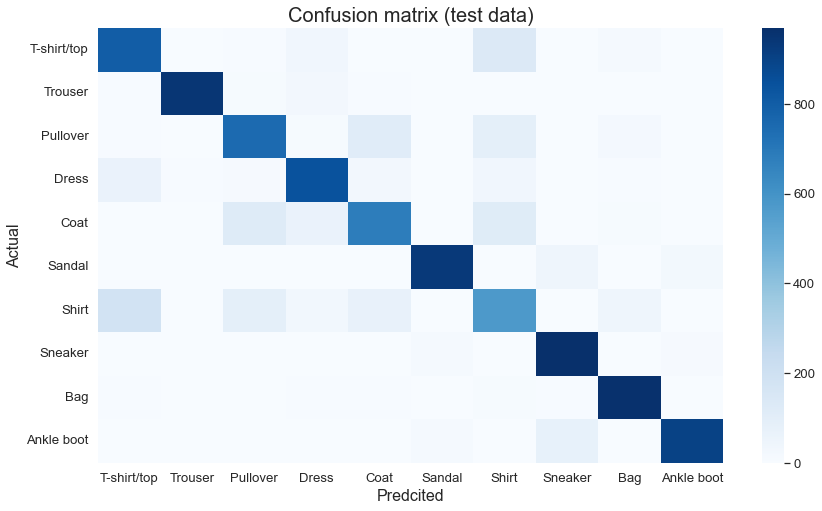

In [333]:
plot_confusion_matrix(np.argmax(y_test,axis=0),pred)

In [296]:

# sample=len(x_train)
# x_tr=x_train[:sample]

# y_tr=y_train[:sample]
